In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from time import sleep
import socket,time,requests
from bs4 import BeautifulSoup
import tkinter as tk
from datetime import date




url="https://uzmanpara.milliyet.com.tr/canli-borsa/bist-TUM-hisseleri/"
r=requests.get(url)
soup=BeautifulSoup(r.content,"html.parser")

bs=BeautifulSoup(r.content, "lxml")
data=soup.find("div",{"class":"box box10 last"})



In [2]:
data=soup.find("tr",{"id":"h_tr_id_SOKM"})


In [3]:
data=soup.find("td",{"id":"h_td_fiyat_id_SOKM"})
text=data.text

In [4]:
text=text.replace(',', '.')
text=float(text)
text

32.3

In [2]:
sok=pd.read_csv("/Users/Bora/Documents/GitHub/Borsa-Hisse-Analizi/ulker.csv")
sok.index=pd.to_datetime(sok["Date"])


In [3]:
del sok["Date"]

In [4]:
sok=pd.DataFrame(sok)

In [5]:
sok

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-02,23.12,22.74,23.30,22.58,894.19K,3.40%
2020-01-03,22.64,23.06,23.08,22.30,918.07K,-2.08%
2020-01-06,22.02,22.40,22.54,21.90,607.63K,-2.74%
2020-01-07,22.80,22.22,22.88,22.22,482.39K,3.54%
2020-01-08,23.30,22.60,23.40,22.40,1.35M,2.19%
...,...,...,...,...,...,...
2023-06-13,33.78,35.20,35.28,33.50,5.45M,-3.98%
2023-06-14,33.10,33.90,34.12,33.00,4.71M,-2.01%
2023-06-15,33.30,33.40,33.66,32.54,6.84M,0.60%


In [6]:
close=pd.DataFrame(sok["Price"])

close


,Price
Date,
2020-01-02,23.12
2020-01-03,22.64
2020-01-06,22.02
2020-01-07,22.80
2020-01-08,23.30
...,...
2023-06-13,33.78
2023-06-14,33.10
2023-06-15,33.30


In [10]:
dict={'Date':date.today(),'Price':text}
df=pd.DataFrame.from_dict(dict,orient="index")
df=df.T
df.reset_index()
df

,Date,Price
0,2023-06-19,32.3


In [11]:
df.set_index=df["Date"]
df

,Date,Price
0,2023-06-19,32.3


In [12]:
df.index=df["Date"]

In [13]:
del df["Date"]

In [14]:
df.index=pd.to_datetime(df.index)
df

,Price
Date,
2023-06-19,32.3


In [16]:
close=pd.concat([close,df])
close

,Price
Date,
2021-01-04,12.89
2021-01-05,13.05
2021-01-06,12.88
2021-01-07,12.95
2021-01-08,13.84
...,...
2023-06-14,30.64
2023-06-15,31.9
2023-06-16,32.3


In [134]:
rolling_app5=close.rolling(window=5).mean()
rolling_app14=close.rolling(window=20).mean()
rolling_app21=close.rolling(window=50).mean()



In [135]:
MAs=pd.concat([close,rolling_app5,rolling_app14,rolling_app21],axis=1)
MAs.columns=["Close","short","mid","long"]


In [136]:
MAs.dropna(axis=0,inplace=True)
MAs

,Close,short,mid,long
Date,,,,
2020-03-11,21.04,21.640,22.163,23.3216
2020-03-12,19.50,21.100,21.955,23.2492
2020-03-13,20.04,20.508,21.784,23.1972
2020-03-16,18.20,19.828,21.534,23.1208
2020-03-17,17.48,19.252,21.242,23.0144
...,...,...,...,...
2023-06-13,33.78,34.684,33.402,32.3948
2023-06-14,33.10,34.180,33.432,32.4336
2023-06-15,33.30,33.964,33.443,32.4856


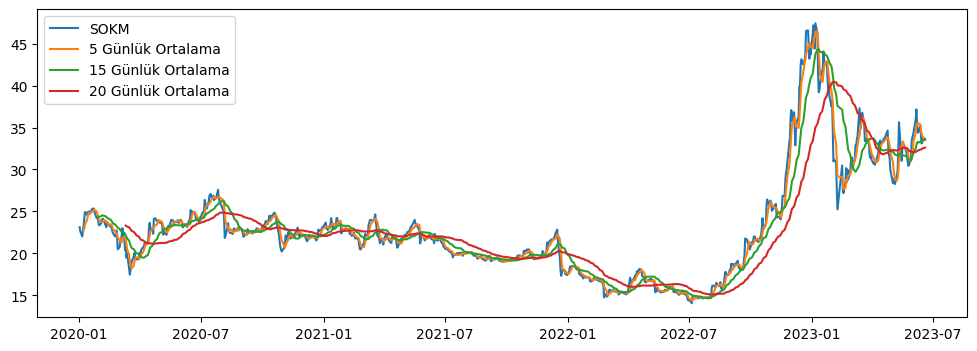

In [137]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(close.index,close,label='SOKM')
ax.plot(rolling_app5.index,rolling_app5,label='5 Günlük Ortalama')
ax.plot(rolling_app14.index,rolling_app14,label='15 Günlük Ortalama')
ax.plot(rolling_app21.index,rolling_app21,label='20 Günlük Ortalama')
ax.legend(loc='upper left')


In [138]:
def buy_sell(data,perc=25):
    buy_sell=[]
    buy_signal=[]
    sell_signal=[]
    flag=42

    sm=np.abs(np.percentile(np.array(data["short"]-data["mid"]),perc))
    sl=np.abs(np.percentile(np.array(data["short"]-data["long"]),perc))

    for i in range(0,len(data)):
        if (data["short"][i]>data["mid"][i]+sm) & (data["short"][i]>data["long"][i]+sl):
            buy_signal.append(np.nan)
            if flag !=1:
                sell_signal.append(data["Close"][i])
                buy_sell.append(data["Close"][i])
                flag=1
            else:
                sell_signal.append(np.nan)
        elif (data["short"][i]<data["mid"][i]-sm)&(data["short"][i]<data["long"][i]-sl):
            sell_signal.append(np.nan)
            if flag!=0:
                buy_signal.append(data["Close"][i])
                buy_sell.append(-data["Close"][i])
                flag=0
            else:
                buy_signal.append(np.nan)
        else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)

    operations=np.array(buy_sell)
    operations=operations[~np.isnan(operations)]

    neg=0
    pos=0

    for i in range(len(operations)):
        if operations[i]<0:
            neg=i
            break
    for i in range(1,len(operations)):
        if operations[-i]>0:
            pos=i-1
            break
    operations=operations[neg:-pos]
    PL=np.sum(operations)

    return (buy_signal,sell_signal,PL)


In [139]:
m=buy_sell(MAs)
MAs["Al"]=m[0]
MAs["Sat"]=m[1]

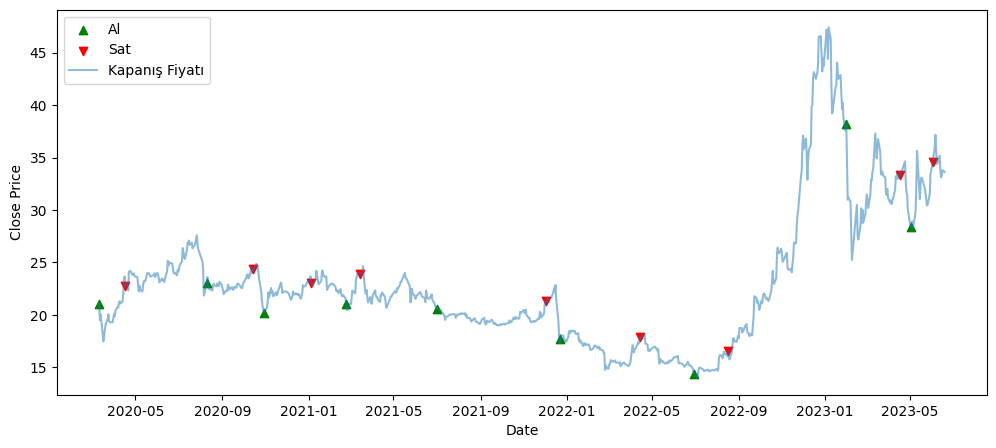

In [140]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Al"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sat"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

In [141]:
al=MAs["Al"]
al=al.dropna(axis=0)
al

Date
2020-03-11    21.04
2020-08-10    23.06
2020-10-30    20.22
2021-02-23    21.00
2021-07-02    20.52
2021-12-23    17.70
2022-06-30    14.39
2023-01-31    38.24
2023-05-02    28.36
Name: Al, dtype: float64

In [142]:
sat=MAs["Sat"]
sat=sat.dropna(axis=0)
sat


Date
2020-04-17    22.80
2020-10-14    24.40
2021-01-05    23.00
2021-03-15    23.94
2021-12-03    21.28
2022-04-14    17.86
2022-08-17    16.57
2023-04-17    33.32
2023-06-02    34.58
Name: Sat, dtype: float64

In [143]:
sat_val=sat.values
al_val=al.values


In [144]:
sat_val1=sat_val

In [145]:
sat_val1

array([22.8 , 24.4 , 23.  , 23.94, 21.28, 17.86, 16.57, 33.32, 34.58])

In [146]:
al_val1=al_val
al_val1

array([21.04, 23.06, 20.22, 21.  , 20.52, 17.7 , 14.39, 38.24, 28.36])

In [147]:
res=[]

for i in range(len(al_val1)):
    res.append((sat_val1[i]/al_val1[i]))

In [148]:
df=pd.DataFrame()
df["Kar"]=res
df

,Kar
0,1.083650
1,1.058109
2,1.137488
3,1.140000
4,1.037037
5,1.009040
6,1.151494
7,0.871339
8,1.219323


In [149]:
res0=[100]
for i in range(len(al_val1)):
    res0.append(res0[i]*df["Kar"].loc[i])


In [150]:
df["Eldeki Para"]=res0[1:]
df

,Kar,Eldeki Para
0,1.083650,108.365019
1,1.058109,114.662032
2,1.137488,130.426644
3,1.140000,148.686374
4,1.037037,154.193277
5,1.009040,155.587114
6,1.151494,179.157643
7,0.871339,156.107026
8,1.219323,190.344886


In [151]:
karlilik=df["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 90.34488569489045


## Her sat tavsiyesinde satmayıp 2.sat tavsiyesinde satarsak ne olur?(Yani 1 adet sat tavsiyesini pas geçersek)

In [69]:
sat_val2=sat_val[1:14:2]

In [70]:
sat_val2

array([24.4 , 23.94, 17.86, 33.32])

In [71]:
al_val2=al_val[0:8:2]
al_val2

array([21.04, 20.22, 20.52, 14.39])

In [72]:
res1=[]

for i in range(4):
    res1.append((sat_val2[i]/al_val2[i]))

In [73]:
df1=pd.DataFrame()
df1["Kar"]=res1
df1

,Kar
0,1.159696
1,1.183976
2,0.870370
3,2.315497


In [74]:
res2=[100]
for i in range(4):
    res2.append(res2[i]*df1["Kar"].loc[i])




In [75]:
df1["Eldeki Para"]=res2[1:]
df1


,Kar,Eldeki Para
0,1.159696,115.969582
1,1.183976,137.305232
2,0.870370,119.506405
3,2.315497,276.716708


In [76]:
karlilik=df1["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 176.7167081228954
